In [1]:
# Imports
import os
import requests
import pandas as pd
#import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv
import yfinance as yf

%matplotlib inline

C:\Users\jorda\anaconda3\envs\pyvizenv\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)



Bad key "text.kerning_factor" on line 4 in
C:\Users\jorda\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
# Stock Shares
my_qqq = 100
my_CM = 1000
my_msft = 100
my_2357 = 100
my_tsla = 100
my_pfe = 1000
my_nvda = 100
my_f = 1000
my_ccl = 1000
my_ac = 1000

# Share Purchase Price
price_qqq = 349.46
price_CM = 23.76
price_msft = 265.02
price_2357 = 367
price_tsla = 671.87
price_pfe = 38.98
price_nvda = 761.24
price_f = 15.19
price_ccl = 28.13
price_ac = 25.91

# Stock Cost Basis
cost_qqq = my_qqq * price_qqq
cost_CM = my_CM * price_CM
cost_msft = my_msft * price_msft
cost_2357 = my_2357 * price_2357
cost_tsla = my_tsla * price_tsla
cost_pfe = my_pfe * price_pfe
cost_nvda = my_nvda * price_nvda
cost_f = my_f * price_f
cost_ccl = my_ccl * price_ccl
cost_ac = my_ac * price_ac

stock_cost = cost_qqq + cost_CM + cost_msft + cost_2357 + cost_tsla + cost_pfe + cost_nvda + cost_f + cost_ccl + cost_ac

# List needs to be alphabetical to allow weights to read in-lin with stock data
stock_weight = [cost_2357/stock_cost,
                    cost_ac/stock_cost, 
                    cost_ccl/stock_cost, 
                    cost_CM/stock_cost, 
                    cost_f/stock_cost, 
                    cost_msft/stock_cost, 
                    cost_nvda/stock_cost, 
                    cost_pfe/stock_cost, 
                    cost_qqq/stock_cost, 
                    cost_tsla/stock_cost]

stock_weight

[0.09827838759175105,
 0.06938400606273214,
 0.07532891125220591,
 0.06362655283869223,
 0.04067707649914709,
 0.07096931411325848,
 0.20385133452409962,
 0.10438396589445383,
 0.09358137691502266,
 0.179919074308637]

In [4]:
# Stock Data
stockStrings = ['QQQ', 'CM-PQ.TO', 'MSFT', '2357.TW', 'TSLA', 'PFE', 'NVDA', 'F', 'CCL', 'AC.TO']

stock_close = yf.download(stockStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
stock_close.to_csv('stocks.csv')

stock_close = stock_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

stock_close = pd.read_csv('stocks.csv', header=[0, 1])
stock_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
stock_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(stock_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
stock_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
stock_close.index.name = None

# Drop Null Information
stock_close = stock_close.dropna()

# Sort Multi-Index To Match Weights
stock_close = stock_close.reindex(sorted(stock_close.columns), axis=1)

stock_close

[*********************100%***********************]  10 of 10 completed


2357.TW                                             AC.TO  \
             Adj Close  Close   High    Low   Open     Volume  Adj Close   
2015-03-11  223.824799  322.0  326.5  322.0  323.0  2017000.0  12.410000   
2015-03-12  225.215042  324.0  325.5  321.5  322.0  1818000.0  12.390000   
2015-03-13  224.172363  322.5  325.0  322.0  323.0  2127000.0  12.210000   
2015-03-16  221.044373  318.0  323.0  316.0  320.0  4840000.0  12.400000   
2015-03-17  220.696838  317.5  322.5  315.0  320.5  3586000.0  12.500000   
...                ...    ...    ...    ...    ...        ...        ...   
2021-06-23  374.000000  374.0  376.5  370.5  375.0  5798938.0  26.770000   
2021-06-24  373.500000  373.5  377.0  372.0  375.0  2744945.0  26.379999   
2021-06-25  367.000000  367.0  375.0  367.0  375.0  6370441.0  25.910000   
2021-06-28  372.500000  372.5  374.0  365.0  368.5  3777733.0  25.360001   
2021-06-29  370.000000  370.0  374.0  370.0  373.0  2028525.0  25.750000   

                                             ...         QQQ              \
                Close       High        Low  ...        High         Low   
2015-03-11  12.410000  12.520000  12.200000  ...  106.010002  105.070000   
2015-03-12  12.390000  12.540000  12.360000  ...  105.919998  104.959999   
2015-03-13  12.210000  12.430000  12.030000  ...  106.120003  104.680000   
2015-03-16  12.400000  12.440000  12.200000  ...  106.739998  105.620003   
2015-03-17  12.500000  12.540000  12.340000  ...  107.040001  106.160004   
...               ...        ...        ...  ...         ...         ...   
2021-06-23  26.770000  27.510000  26.770000  ...  348.920013  346.880005   
2021-06-24  26.379999  27.070000  26.320000  ...  351.459991  349.170013   
2021-06-25  25.910000  26.459999  25.900000  ...  350.720001  348.839996   
2021-06-28  25.360001  26.000000  25.110001  ...  353.850006  350.720001   
2021-06-29  25.750000  25.920000  25.240000  ...  355.019897  352.670013   

                                          TSLA                          \
                  Open      Volume   Adj Close       Close        High   
2015-03-11  105.879997  25459700.0   38.748001   38.748001   39.236000   
2015-03-12  105.029999  21473200.0   38.214001   38.214001   38.889999   
2015-03-13  105.699997  42021100.0   37.736000   37.736000   38.349998   
2015-03-16  105.730003  25674100.0   39.139999   39.139999   39.181999   
2015-03-17  106.410004  19603800.0   38.945999   38.945999   39.742001   
...                ...         ...         ...         ...         ...   
2021-06-23  347.510010  27188500.0  656.570007  656.570007  657.200012   
2021-06-24  349.730011  32581600.0  679.820007  679.820007  697.619995   
2021-06-25  350.470001  28627400.0  671.869995  671.869995  693.809998   
2021-06-28  350.779999  38934900.0  688.719971  688.719971  694.700012   
2021-06-29  353.529999  27855614.0  680.760010  680.760010  687.509888   

                                                
                   Low        Open      Volume  
2015-03-11   38.202000   38.230000  24874500.0  
2015-03-12   37.950001   38.750000  20746500.0  
2015-03-13   37.464001   37.790001  27171500.0  
2015-03-16   37.959999   38.400002  28144000.0  
2015-03-17   38.787998   39.085999  24470500.0  
...                ...         ...         ...  
2021-06-23  630.039978  632.000000  31099200.0  
2021-06-24  667.609985  674.989990  45982400.0  
2021-06-25  668.700012  689.580017  32429000.0  
2021-06-28  670.320007  671.640015  21591000.0  
2021-06-29  675.890015  684.650024  17175376.0  

[1463 rows x 60 columns]

In [5]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_stock_one_year = MCSimulation(
    portfolio_data = stock_close,
    weights = stock_weight,
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [6]:
# Printing the simulation input data
MC_stock_one_year.portfolio_data.head()

2357.TW                                                      \
             Adj Close  Close   High    Low   Open     Volume daily_return   
2015-03-11  223.824799  322.0  326.5  322.0  323.0  2017000.0          NaN   
2015-03-12  225.215042  324.0  325.5  321.5  322.0  1818000.0     0.006211   
2015-03-13  224.172363  322.5  325.0  322.0  323.0  2127000.0    -0.004630   
2015-03-16  221.044373  318.0  323.0  316.0  320.0  4840000.0    -0.013953   
2015-03-17  220.696838  317.5  322.5  315.0  320.5  3586000.0    -0.001572   

               AC.TO                ...         QQQ                           \
           Adj Close  Close   High  ...        Open      Volume daily_return   
2015-03-11     12.41  12.41  12.52  ...  105.879997  25459700.0          NaN   
2015-03-12     12.39  12.39  12.54  ...  105.029999  21473200.0     0.006565   
2015-03-13     12.21  12.21  12.43  ...  105.699997  42021100.0    -0.004348   
2015-03-16     12.40  12.40  12.44  ...  105.730003  25674100.0     0.012911   
2015-03-17     12.50  12.50  12.54  ...  106.410004  19603800.0     0.001593   

                 TSLA                                                          \
            Adj Close      Close       High        Low       Open      Volume   
2015-03-11  38.748001  38.748001  39.236000  38.202000  38.230000  24874500.0   
2015-03-12  38.214001  38.214001  38.889999  37.950001  38.750000  20746500.0   
2015-03-13  37.736000  37.736000  38.349998  37.464001  37.790001  27171500.0   
2015-03-16  39.139999  39.139999  39.181999  37.959999  38.400002  28144000.0   
2015-03-17  38.945999  38.945999  39.742001  38.787998  39.085999  24470500.0   

                         
           daily_return  
2015-03-11          NaN  
2015-03-12    -0.013781  
2015-03-13    -0.012509  
2015-03-16     0.037206  
2015-03-17    -0.004957  

[5 rows x 70 columns]

In [7]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_stock_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.010875  0.996976  0.996078  1.014528  0.978600  0.989014  0.999244   
2    1.014167  0.987904  1.013785  0.998128  0.983202  1.004759  1.000587   
3    1.011170  0.978463  1.007474  0.979792  0.973589  1.004324  0.997781   
4    1.010937  0.981786  1.016540  0.982997  0.987531  1.012324  0.995365   
..        ...       ...       ...       ...       ...       ...       ...   
248  1.426335  1.179322  1.155933  0.999759  1.282546  1.079504  1.344405   
249  1.426668  1.209438  1.167773  1.019556  1.284901  1.085327  1.354415   
250  1.429183  1.202864  1.174617  1.020376  1.294623  1.090994  1.358271   
251  1.410682  1.211879  1.167133  1.025518  1.310868  1.101287  1.371105   
252  1.411454  1.201767  1.152000  1.031782  1.299566  1.081024  1.356200   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.007475  1.001643  1.009079  ...  1.004539  0.998490  0.995384   
2    1.002768  1.005287  1.007621  ...  1.008364  0.994077  1.012756   
3    1.004782  1.013859  1.020916  ...  1.008532  0.994469  1.011939   
4    1.000817  1.018449  1.022200  ...  1.022079  0.996577  1.010783   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.916777  1.280066  1.339177  ...  1.174588  1.332607  1.056930   
249  1.944689  1.304813  1.354730  ...  1.204328  1.352418  1.039074   
250  1.923449  1.287267  1.337840  ...  1.214947  1.352213  1.058748   
251  1.946726  1.280877  1.336563  ...  1.213335  1.372763  1.085077   
252  1.952213  1.274324  1.321059  ...  1.220229  1.403627  1.100209   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    1.014539  0.994707  1.002079  0.998489  0.993928  1.007112  0.992764  
2    1.040211  0.995575  1.010049  1.008735  0.972928  1.020282  0.984038  
3    1.050597  0.985830  1.002332  1.003509  0.969193  1.037803  0.977793  
4    1.042777  0.980798  1.014167  1.001866  0.979824  1.056010  0.974117  
..        ...       ...       ...       ...       ...       ...       ...  
248  1.506257  1.514294  1.523841  1.275385  1.308900  1.594470  1.284939  
249  1.519076  1.523110  1.496714  1.240909  1.278004  1.564398  1.298237  
250  1.543307  1.533095  1.482523  1.211166  1.296044  1.563911  1.296555  
251  1.566789  1.553544  1.492794  1.198612  1.330065  1.560798  1.300224  
252  1.567453  1.544194  1.517608  1.201519  1.315738  1.557459  1.310045  

[253 rows x 500 columns]

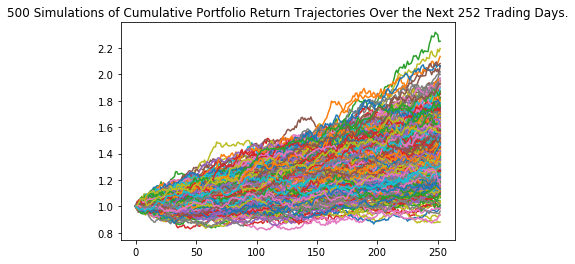

In [8]:
# Plot simulation outcomes
stock_oneyr_line_plot = MC_stock_one_year.plot_simulation()

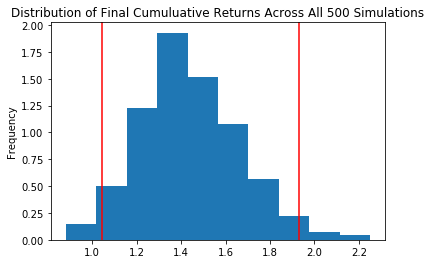

In [9]:
# Plot probability distribution and confidence intervals
stock_oneyr_dist_plot = MC_stock_one_year.plot_distribution()

In [10]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_oneyr_tbl = MC_stock_one_year.summarize_cumulative_return()

# Print summary statistics
print(stock_oneyr_tbl)

count           500.000000
mean              1.445129
std               0.221632
min               0.881634
25%               1.287210
50%               1.420572
75%               1.582398
max               2.250455
95% CI Lower      1.042928
95% CI Upper      1.932043
Name: 252, dtype: float64


In [11]:
# Configuring a Monte Carlo simulation to forecast 5 year cumulative returns
MC_stock_five_year = MCSimulation(
    portfolio_data = stock_close,
    weights = stock_weight,
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [12]:
# Printing the simulation input data
MC_stock_five_year.portfolio_data.head()

2357.TW                                                      \
             Adj Close  Close   High    Low   Open     Volume daily_return   
2015-03-11  223.824799  322.0  326.5  322.0  323.0  2017000.0          NaN   
2015-03-12  225.215042  324.0  325.5  321.5  322.0  1818000.0     0.006211   
2015-03-13  224.172363  322.5  325.0  322.0  323.0  2127000.0    -0.004630   
2015-03-16  221.044373  318.0  323.0  316.0  320.0  4840000.0    -0.013953   
2015-03-17  220.696838  317.5  322.5  315.0  320.5  3586000.0    -0.001572   

               AC.TO                ...         QQQ                           \
           Adj Close  Close   High  ...        Open      Volume daily_return   
2015-03-11     12.41  12.41  12.52  ...  105.879997  25459700.0          NaN   
2015-03-12     12.39  12.39  12.54  ...  105.029999  21473200.0     0.006565   
2015-03-13     12.21  12.21  12.43  ...  105.699997  42021100.0    -0.004348   
2015-03-16     12.40  12.40  12.44  ...  105.730003  25674100.0     0.012911   
2015-03-17     12.50  12.50  12.54  ...  106.410004  19603800.0     0.001593   

                 TSLA                                                          \
            Adj Close      Close       High        Low       Open      Volume   
2015-03-11  38.748001  38.748001  39.236000  38.202000  38.230000  24874500.0   
2015-03-12  38.214001  38.214001  38.889999  37.950001  38.750000  20746500.0   
2015-03-13  37.736000  37.736000  38.349998  37.464001  37.790001  27171500.0   
2015-03-16  39.139999  39.139999  39.181999  37.959999  38.400002  28144000.0   
2015-03-17  38.945999  38.945999  39.742001  38.787998  39.085999  24470500.0   

                         
           daily_return  
2015-03-11          NaN  
2015-03-12    -0.013781  
2015-03-13    -0.012509  
2015-03-16     0.037206  
2015-03-17    -0.004957  

[5 rows x 70 columns]

In [13]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_stock_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1          2         3         4         5         6    \
0     1.000000  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.014044  0.989824   1.011270  0.999292  1.010332  1.004196  1.013964   
2     1.020309  0.987931   1.017346  1.007436  1.017290  0.995348  1.009278   
3     1.023199  0.995278   1.026243  1.028893  1.006144  0.986538  1.021900   
4     1.031758  1.020703   1.048269  1.048082  0.994490  0.983002  1.018509   
...        ...       ...        ...       ...       ...       ...       ...   
1256  6.180281  4.867697  12.324428  7.090278  7.288793  8.238182  4.265753   
1257  6.286644  4.833752  12.412511  7.099667  7.394348  8.195900  4.353660   
1258  6.372933  4.846215  12.335910  7.141504  7.372284  8.165196  4.420441   
1259  6.455785  4.838726  12.337845  7.236506  7.347694  8.091837  4.365912   
1260  6.587277  4.891925  12.089412  7.003299  7.334188  8.124930  4.397417   

           7         8         9    ...        490       491       492  \
0     1.000000  1.000000  1.000000  ...   1.000000  1.000000  1.000000   
1     1.002378  1.002734  1.003808  ...   0.999945  1.008654  1.002994   
2     1.009670  1.014373  1.005527  ...   0.998450  1.020101  0.996710   
3     1.008130  1.010403  1.013858  ...   1.008270  1.014011  0.993142   
4     1.011753  0.992459  1.030380  ...   1.004538  1.011090  0.995932   
...        ...       ...       ...  ...        ...       ...       ...   
1256  3.902699  3.407265  7.041453  ...  15.382248  2.415345  4.011478   
1257  3.884153  3.390648  7.083875  ...  15.512372  2.450746  4.005860   
1258  3.886331  3.356938  7.143902  ...  15.755878  2.385302  4.043211   
1259  3.991560  3.391636  7.145399  ...  15.569651  2.398929  4.089269   
1260  4.002048  3.397010  7.229823  ...  15.461411  2.436751  4.142589   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.985672  1.009469  0.999898  1.016949  1.000517  1.006239  0.985730  
2     0.998028  1.020177  1.013453  1.023985  1.012503  1.002063  0.995062  
3     0.997231  1.023772  1.020555  1.022344  0.993055  1.006399  0.997552  
4     0.995811  1.034110  1.007103  1.033594  1.006078  1.029655  1.000765  
...        ...       ...       ...       ...       ...       ...       ...  
1256  3.967955  5.618538  5.301643  5.535875  4.534078  2.639226  5.275413  
1257  4.001877  5.654110  5.248213  5.490072  4.573408  2.681484  5.381289  
1258  4.010204  5.689921  5.282548  5.488464  4.574964  2.728593  5.377038  
1259  3.995386  5.786686  5.286907  5.519421  4.625474  2.743033  5.445570  
1260  4.012445  5.885963  5.230945  5.635747  4.629614  2.785232  5.496867  

[1261 rows x 500 columns]

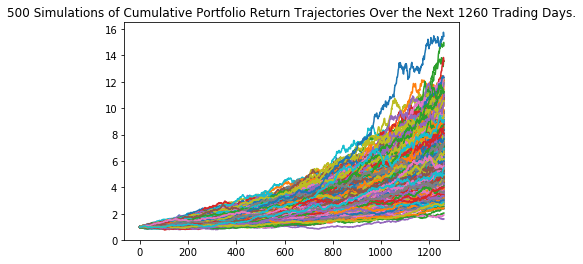

In [14]:
# Plot simulation outcomes
stock_fiveyr_line_plot = MC_stock_five_year.plot_simulation()

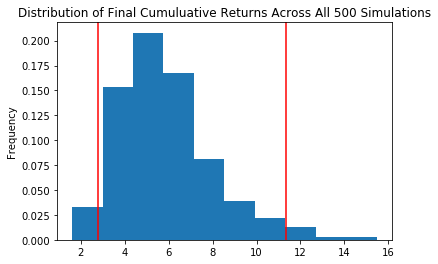

In [15]:
# Plot probability distribution and confidence intervals
Stock_fiveyr_dist_plot = MC_stock_five_year.plot_distribution()

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_fiveyr_tbl = MC_stock_five_year.summarize_cumulative_return()

# Print summary statistics
print(stock_fiveyr_tbl)

count           500.000000
mean              5.876061
std               2.178651
min               1.609819
25%               4.248232
50%               5.598419
75%               7.003373
max              15.461411
95% CI Lower      2.782373
95% CI Upper     11.358730
Name: 1260, dtype: float64


In [17]:
# Crypto
my_btc = 1
my_eth = 10
my_ada = 10000
my_link = 1000
my_ltc = 100

# Crypto Purchase Price
price_btc = 32870.84
price_eth = 1865.51
price_ada = 1.2902
price_link = 17.25
price_ltc = 128.45

# Crypto Cost Basis
cost_btc = my_btc * price_btc
cost_eth = my_eth * price_eth
cost_ada = my_ada * price_ada
cost_link = my_link * price_link
cost_ltc = my_ltc * price_ltc

crypto_cost = cost_btc + cost_eth + cost_ada + cost_link + cost_ltc

# List needs to be alphabetical to allow weights to read in-lin with stock data
crypto_weight = [cost_ada/crypto_cost, 
                    cost_btc/crypto_cost, 
                    cost_eth/crypto_cost, 
                    cost_link/crypto_cost, 
                    cost_ltc/crypto_cost]

crypto_weight

[0.13649596595281527,
 0.34775515869480994,
 0.19736055607242006,
 0.1824953815444166,
 0.13589293773553804]

In [18]:
# Crypto Data
cryptoStrings = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'LINK-USD', 'LTC-USD']

crypto_close = yf.download(cryptoStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
crypto_close.to_csv('crypto.csv')

crypto_close = crypto_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

crypto_close = pd.read_csv('crypto.csv', header=[0, 1])
crypto_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
crypto_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(crypto_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
crypto_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
crypto_close.index.name = None

# Drop Null Information
crypto_close = crypto_close.dropna()

# Sort Multi-Index To Match Weights
crypto_close = crypto_close.reindex(sorted(crypto_close.columns), axis=1)

crypto_close

[*********************100%***********************]  5 of 5 completed


ADA-USD                                                        \
           Adj Close     Close      High       Low      Open        Volume   
2017-10-01  0.024969  0.024969  0.032226  0.017354  0.021678  5.006870e+07   
2017-10-02  0.025932  0.025932  0.030088  0.019969  0.024607  5.764130e+07   
2017-10-03  0.020816  0.020816  0.027425  0.020690  0.025757  1.699780e+07   
2017-10-04  0.021931  0.021931  0.022806  0.020864  0.020864  9.000050e+06   
2017-10-05  0.021489  0.021489  0.022154  0.020859  0.021951  5.562510e+06   
...              ...       ...       ...       ...       ...           ...   
2021-06-25  1.256478  1.256478  1.392683  1.245304  1.359522  4.343177e+09   
2021-06-26  1.250440  1.250440  1.291396  1.198573  1.254301  3.241468e+09   
2021-06-27  1.335202  1.335202  1.348168  1.243678  1.251827  2.371577e+09   
2021-06-28  1.324752  1.324752  1.349285  1.305406  1.337114  2.292441e+09   
2021-06-29  1.372028  1.372028  1.417712  1.320982  1.332126  2.595155e+09   

                 BTC-USD                                            ...  \
               Adj Close         Close          High           Low  ...   
2017-10-01   4403.740234   4403.740234   4403.740234   4269.810059  ...   
2017-10-02   4409.319824   4409.319824   4470.229980   4377.459961  ...   
2017-10-03   4317.479980   4317.479980   4432.470215   4258.890137  ...   
2017-10-04   4229.359863   4229.359863   4352.310059   4210.419922  ...   
2017-10-05   4328.410156   4328.410156   4362.640137   4164.049805  ...   
...                  ...           ...           ...           ...  ...   
2021-06-25  31637.779297  31637.779297  35487.246094  31350.884766  ...   
2021-06-26  32186.277344  32186.277344  32637.587891  30184.501953  ...   
2021-06-27  34649.644531  34649.644531  34656.128906  32071.757812  ...   
2021-06-28  34434.335938  34434.335938  35219.890625  33902.074219  ...   
2021-06-29  35809.406250  35809.406250  36542.109375  34252.484375  ...   

             LINK-USD                                         LTC-USD  \
                 High        Low       Open        Volume   Adj Close   
2017-10-01   0.451884   0.382034   0.451547  1.000510e+07   54.543301   
2017-10-02   0.440264   0.356767   0.437667  7.101340e+06   53.375999   
2017-10-03   0.367254   0.295817   0.367254  8.211990e+06   52.349602   
2017-10-04   0.398695   0.336883   0.343186  7.604930e+06   51.399502   
2017-10-05   0.417906   0.378043   0.397030  6.291110e+06   51.669498   
...               ...        ...        ...           ...         ...   
2021-06-25  19.472569  16.835096  19.051491  1.099375e+09  125.687744   
2021-06-26  17.485468  15.957306  16.897558  9.569999e+08  126.657257   
2021-06-27  18.367485  16.628080  16.969868  8.055224e+08  132.347885   
2021-06-28  19.406273  17.931026  18.381657  9.253744e+08  137.370850   
2021-06-29  20.533747  18.858234  18.858234  9.478113e+08  144.112686   

                                                                          
                 Close        High         Low        Open        Volume  
2017-10-01   54.543301   55.161598   53.625198   55.136200  1.001830e+08  
2017-10-02   53.375999   54.784801   53.257999   54.546902  9.547460e+07  
2017-10-03   52.349602   53.592999   51.586601   53.390400  8.851610e+07  
2017-10-04   51.399502   53.046101   50.830399   52.284302  7.747340e+07  
2017-10-05   51.669498   51.865501   50.440498   51.401402  6.959440e+07  
...                ...         ...         ...         ...           ...  
2021-06-25  125.687744  138.119720  124.581169  134.596222  1.912813e+09  
2021-06-26  126.657257  129.304077  119.029800  125.393433  2.064657e+09  
2021-06-27  132.347885  132.476059  125.090523  126.893791  1.804264e+09  
2021-06-28  137.370850  139.474335  130.304153  132.592697  1.877530e+09  
2021-06-29  144.112686  148.922623  137.423492  138.992004  2.164198e+09  

[1364 rows x 30 columns]

In [19]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_crypto_one_year = MCSimulation(
    portfolio_data = crypto_close,
    weights = crypto_weight,
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [20]:
# Printing the simulation input data
MC_crypto_one_year.portfolio_data.head()

ADA-USD                                                      \
           Adj Close     Close      High       Low      Open      Volume   
2017-10-01  0.024969  0.024969  0.032226  0.017354  0.021678  50068700.0   
2017-10-02  0.025932  0.025932  0.030088  0.019969  0.024607  57641300.0   
2017-10-03  0.020816  0.020816  0.027425  0.020690  0.025757  16997800.0   
2017-10-04  0.021931  0.021931  0.022806  0.020864  0.020864   9000050.0   
2017-10-05  0.021489  0.021489  0.022154  0.020859  0.021951   5562510.0   

                             BTC-USD                            ...  LINK-USD  \
           daily_return    Adj Close        Close         High  ...      Open   
2017-10-01          NaN  4403.740234  4403.740234  4403.740234  ...  0.451547   
2017-10-02     0.038568  4409.319824  4409.319824  4470.229980  ...  0.437667   
2017-10-03    -0.197285  4317.479980  4317.479980  4432.470215  ...  0.367254   
2017-10-04     0.053565  4229.359863  4229.359863  4352.310059  ...  0.343186   
2017-10-05    -0.020154  4328.410156  4328.410156  4362.640137  ...  0.397030   

                                       LTC-USD                        \
                Volume daily_return  Adj Close      Close       High   
2017-10-01  10005100.0          NaN  54.543301  54.543301  55.161598   
2017-10-02   7101340.0    -0.182940  53.375999  53.375999  54.784801   
2017-10-03   8211990.0    -0.031483  52.349602  52.349602  53.592999   
2017-10-04   7604930.0     0.149988  51.399502  51.399502  53.046101   
2017-10-05   6291110.0     0.023095  51.669498  51.669498  51.865501   

                                                            
                  Low       Open       Volume daily_return  
2017-10-01  53.625198  55.136200  100183000.0          NaN  
2017-10-02  53.257999  54.546902   95474600.0    -0.021401  
2017-10-03  51.586601  53.390400   88516096.0    -0.019230  
2017-10-04  50.830399  52.284302   77473400.0    -0.018149  
2017-10-05  50.440498  51.401402   69594400.0     0.005253  

[5 rows x 35 columns]

In [21]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_crypto_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.011093  1.027633  1.015360  1.035809  0.988119  1.013473  0.961759   
2    1.013696  1.016058  1.072841  1.048204  0.954657  1.040758  0.984102   
3    1.044180  1.042343  1.097711  1.074897  0.912557  1.048493  1.006513   
4    1.066931  1.006194  1.105643  1.075327  0.917200  1.032308  1.032428   
..        ...       ...       ...       ...       ...       ...       ...   
248  2.329595  1.213267  1.566099  1.804236  1.418613  1.694979  2.547072   
249  2.382523  1.250980  1.578728  1.799575  1.359686  1.694296  2.614510   
250  2.301426  1.212880  1.518143  1.815041  1.412054  1.697326  2.507067   
251  2.277143  1.241729  1.539648  1.790204  1.394293  1.667880  2.645377   
252  2.277369  1.315171  1.493845  1.791480  1.418078  1.730435  2.702321   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.017588  0.995853  1.005745  ...  1.006430  1.024803  1.006952   
2    1.028435  0.999591  0.990527  ...  0.972569  1.018009  1.041533   
3    1.019021  1.014616  1.011071  ...  0.981453  1.021803  1.009183   
4    1.019369  1.041729  1.060120  ...  0.958488  1.034460  1.004877   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.744853  4.061799  1.116295  ...  2.103852  2.763449  2.881621   
249  1.770936  4.076254  1.128762  ...  2.100638  2.771259  2.773226   
250  1.773344  4.070601  1.152633  ...  2.159925  2.526444  2.916250   
251  1.783222  4.230399  1.229428  ...  2.124384  2.608150  2.954342   
252  1.795709  4.014291  1.216667  ...  2.101934  2.558051  2.990304   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    1.004215  0.989431  1.038357  0.999826  1.024406  1.015554  0.997750  
2    0.977005  1.001776  1.119196  0.983072  1.057944  1.047716  0.958905  
3    0.991753  0.995846  1.079580  1.022812  1.113052  1.072659  0.994582  
4    0.974346  0.993010  1.077223  1.102041  1.099142  1.065862  0.984723  
..        ...       ...       ...       ...       ...       ...       ...  
248  2.041902  1.092852  5.942927  2.993598  4.706951  4.770102  2.149115  
249  2.013930  1.081595  5.950512  2.972842  4.932192  4.825147  2.059707  
250  2.080693  1.039786  5.879624  3.141571  4.748308  4.929490  2.034943  
251  2.082974  1.037833  5.629382  3.067366  4.855125  5.042977  2.038860  
252  2.060144  1.017613  5.597846  3.153081  5.115791  5.034836  2.043848  

[253 rows x 500 columns]

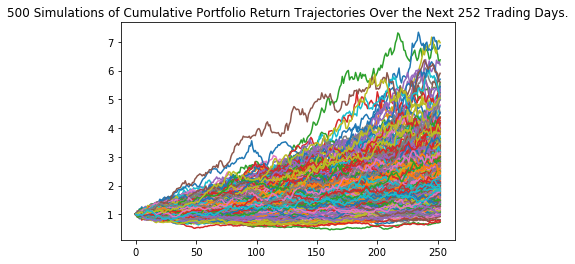

In [22]:
# Plot simulation outcomes
crypto_oneyr_line_plot = MC_crypto_one_year.plot_simulation()

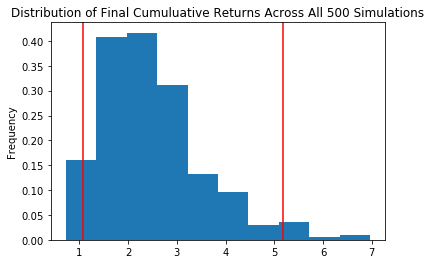

In [23]:
# Plot probability distribution and confidence intervals
crypto_oneyr_dist_plot = MC_crypto_one_year.plot_distribution()

In [24]:
# Fetch summary statistics from the Monte Carlo simulation results
crypto_oneyr_tbl = MC_crypto_one_year.summarize_cumulative_return()

# Print summary statistics
print(crypto_oneyr_tbl)

count           500.000000
mean              2.490446
std               1.045892
min               0.723960
25%               1.743394
50%               2.310858
75%               2.975990
max               6.966150
95% CI Lower      1.072711
95% CI Upper      5.185837
Name: 252, dtype: float64


In [25]:
# Configuring a Monte Carlo simulation to forecast 5 year cumulative returns
MC_crypto_five_year = MCSimulation(
    portfolio_data = crypto_close,
    weights = crypto_weight,
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [26]:
# Printing the simulation input data
MC_crypto_five_year.portfolio_data.head()

ADA-USD                                                      \
           Adj Close     Close      High       Low      Open      Volume   
2017-10-01  0.024969  0.024969  0.032226  0.017354  0.021678  50068700.0   
2017-10-02  0.025932  0.025932  0.030088  0.019969  0.024607  57641300.0   
2017-10-03  0.020816  0.020816  0.027425  0.020690  0.025757  16997800.0   
2017-10-04  0.021931  0.021931  0.022806  0.020864  0.020864   9000050.0   
2017-10-05  0.021489  0.021489  0.022154  0.020859  0.021951   5562510.0   

                             BTC-USD                            ...  LINK-USD  \
           daily_return    Adj Close        Close         High  ...      Open   
2017-10-01          NaN  4403.740234  4403.740234  4403.740234  ...  0.451547   
2017-10-02     0.038568  4409.319824  4409.319824  4470.229980  ...  0.437667   
2017-10-03    -0.197285  4317.479980  4317.479980  4432.470215  ...  0.367254   
2017-10-04     0.053565  4229.359863  4229.359863  4352.310059  ...  0.343186   
2017-10-05    -0.020154  4328.410156  4328.410156  4362.640137  ...  0.397030   

                                       LTC-USD                        \
                Volume daily_return  Adj Close      Close       High   
2017-10-01  10005100.0          NaN  54.543301  54.543301  55.161598   
2017-10-02   7101340.0    -0.182940  53.375999  53.375999  54.784801   
2017-10-03   8211990.0    -0.031483  52.349602  52.349602  53.592999   
2017-10-04   7604930.0     0.149988  51.399502  51.399502  53.046101   
2017-10-05   6291110.0     0.023095  51.669498  51.669498  51.865501   

                                                            
                  Low       Open       Volume daily_return  
2017-10-01  53.625198  55.136200  100183000.0          NaN  
2017-10-02  53.257999  54.546902   95474600.0    -0.021401  
2017-10-03  51.586601  53.390400   88516096.0    -0.019230  
2017-10-04  50.830399  52.284302   77473400.0    -0.018149  
2017-10-05  50.440498  51.401402   69594400.0     0.005253  

[5 rows x 35 columns]

In [27]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_crypto_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0          1          2         3          4           5    \
0      1.000000   1.000000   1.000000  1.000000   1.000000    1.000000   
1      0.990225   1.019982   0.979613  1.027636   1.002221    1.024886   
2      0.980878   1.030015   1.018792  1.083188   0.972226    1.032292   
3      1.034895   1.024385   1.075439  1.155629   1.003794    0.975746   
4      1.069859   1.022744   1.081230  1.122598   1.018140    0.988136   
...         ...        ...        ...       ...        ...         ...   
1256  35.338528  24.304632  57.634780  6.919867  68.702581  124.840713   
1257  34.771956  24.040487  59.651086  6.901036  69.057597  124.009422   
1258  37.707749  24.441123  61.766901  6.973292  65.594262  123.761896   
1259  39.052573  24.692348  66.258451  7.038455  69.889375  125.268565   
1260  38.667502  24.540038  66.370292  7.084298  73.089248  131.670962   

             6           7          8          9    ...        490        491  \
0       1.000000    1.000000   1.000000   1.000000  ...   1.000000   1.000000   
1       0.981078    1.029261   0.988486   1.000337  ...   0.990112   1.038163   
2       0.978299    1.027572   0.988196   0.980837  ...   0.996881   1.101698   
3       0.950450    1.040999   0.977760   0.987829  ...   1.025347   1.111577   
4       0.964720    1.066495   1.014079   0.934164  ...   0.982601   1.109452   
...          ...         ...        ...        ...  ...        ...        ...   
1256  297.105116  316.438701  39.052382  15.504034  ...  23.362184  56.952257   
1257  306.206614  315.059470  41.025890  15.267623  ...  23.688356  59.204772   
1258  308.751123  327.844950  40.645592  15.025612  ...  22.828097  58.424102   
1259  309.026793  328.387961  40.825650  15.409183  ...  23.509197  58.944491   
1260  310.875771  326.553779  40.706760  15.163156  ...  23.209912  58.308194   

             492        493         494        495         496        497  \
0       1.000000   1.000000    1.000000   1.000000    1.000000   1.000000   
1       1.016097   1.001415    0.969591   1.003835    0.995126   1.005686   
2       1.030529   1.005923    0.978392   1.015707    0.974075   0.972120   
3       1.060002   0.996259    0.961082   1.001740    0.949634   1.000022   
4       1.087436   0.964932    0.951028   0.997853    0.983273   1.020028   
...          ...        ...         ...        ...         ...        ...   
1256  204.013032  31.495049  137.030543  15.146265  102.611729  90.529124   
1257  206.649842  34.283676  131.519924  15.365850  102.893032  85.866957   
1258  209.358883  34.455537  132.597231  15.891814  101.987474  88.057669   
1259  210.122235  34.598038  135.021225  15.221801  102.237690  85.112207   
1260  209.913121  34.495995  133.791052  15.523598  102.881720  82.170625   

            498        499  
0      1.000000   1.000000  
1      0.972262   1.015417  
2      0.990514   0.995216  
3      0.970507   1.036732  
4      1.000726   1.081305  
...         ...        ...  
1256  17.205689  18.703378  
1257  17.457218  18.245897  
1258  17.231155  18.037526  
1259  17.258222  17.472737  
1260  16.782516  17.902747  

[1261 rows x 500 columns]

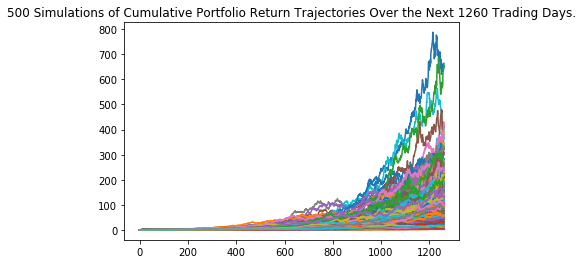

In [28]:
# Plot simulation outcomes
crypto_fiveyr_line_plot = MC_crypto_five_year.plot_simulation()

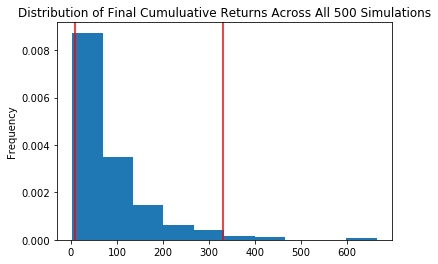

In [29]:
# Plot probability distribution and confidence intervals
crypto_fiveyr_dist_plot = MC_crypto_five_year.plot_distribution()

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
crypto_fiveyr_tbl = MC_crypto_five_year.summarize_cumulative_return()

# Print summary statistics
print(crypto_fiveyr_tbl)

count           500.000000
mean             87.346755
std              87.689171
min               2.505137
25%              31.096891
50%              56.267339
75%             115.013549
max             663.739995
95% CI Lower      8.783899
95% CI Upper    329.603911
Name: 1260, dtype: float64


In [31]:
# S&P 500 and AGG Data for comparison to the traditional 60/40 stocks and bonds portfolio
spbondStrings = ['AGG', 'SPY']

spagg_close = yf.download(spbondStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
spagg_close.to_csv('spagg.csv')

spagg_close = spagg_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

spagg_close = pd.read_csv('spagg.csv', header=[0, 1])
spagg_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
spagg_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(spagg_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
spagg_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
spagg_close.index.name = None

# Drop Null Information
spagg_close = spagg_close.dropna()

# Sort Multi-Index To Match Weights
spagg_close = spagg_close.reindex(sorted(spagg_close.columns), axis=1)

spagg_close

[*********************100%***********************]  2 of 2 completed


AGG                                                  \
             Adj Close       Close        High         Low        Open   
2011-06-30   82.949669  106.669998  106.910004  106.400002  106.870003   
2011-07-01   82.976189  106.400002  106.540001  106.269997  106.500000   
2011-07-05   83.295906  106.809998  106.820000  106.570000  106.570000   
2011-07-06   83.342690  106.870003  106.930000  106.760002  106.790001   
2011-07-07   83.108749  106.570000  106.669998  106.449997  106.629997   
...                ...         ...         ...         ...         ...   
2021-06-23  115.050003  115.050003  115.139999  114.989998  115.059998   
2021-06-24  115.089996  115.089996  115.169998  115.050003  115.099998   
2021-06-25  114.860001  114.860001  115.129997  114.750000  115.110001   
2021-06-28  115.190002  115.190002  115.230003  115.040001  115.040001   
2021-06-29  115.250000  115.250000  115.250000  115.050003  115.059998   

                              SPY                                      \
               Volume   Adj Close       Close        High         Low   
2011-06-30  1295600.0  108.803261  131.970001  132.179993  130.710007   
2011-07-01  1970000.0  110.410950  133.919998  134.100006  131.779999   
2011-07-05   799200.0  110.320297  133.809998  134.080002  133.389999   
2011-07-06   774600.0  110.452179  133.970001  134.139999  133.110001   
2011-07-07  1291600.0  111.598183  135.360001  135.699997  134.880005   
...               ...         ...         ...         ...         ...   
2021-06-23  5070500.0  422.600006  422.600006  424.049988  422.510010   
2021-06-24  8357900.0  425.100006  425.100006  425.549988  424.619995   
2021-06-25  6496600.0  426.609985  426.609985  427.089996  425.549988   
2021-06-28  5739000.0  427.470001  427.470001  427.649994  425.890015   
2021-06-29  4143838.0  427.700012  427.700012  428.559998  427.130005   

                                     
                  Open       Volume  
2011-06-30  131.139999  223322700.0  
2011-07-01  132.089996  202385700.0  
2011-07-05  133.779999  165936000.0  
2011-07-06  133.490005  143331600.0  
2011-07-07  135.160004  170464200.0  
...                ...          ...  
2021-06-23  423.190002   49445400.0  
2021-06-24  424.890015   45110300.0  
2021-06-25  425.899994   58067900.0  
2021-06-28  427.170013   53090800.0  
2021-06-29  427.880005   34946598.0  

[2516 rows x 12 columns]

In [32]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_spagg_one_year = MCSimulation(
    portfolio_data = spagg_close,
    weights = [0.40, 0.60],
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [33]:
# Printing the simulation input data
MC_spagg_one_year.portfolio_data.head()

AGG                                                  \
            Adj Close       Close        High         Low        Open   
2011-06-30  82.949669  106.669998  106.910004  106.400002  106.870003   
2011-07-01  82.976189  106.400002  106.540001  106.269997  106.500000   
2011-07-05  83.295906  106.809998  106.820000  106.570000  106.570000   
2011-07-06  83.342690  106.870003  106.930000  106.760002  106.790001   
2011-07-07  83.108749  106.570000  106.669998  106.449997  106.629997   

                                           SPY                          \
               Volume daily_return   Adj Close       Close        High   
2011-06-30  1295600.0          NaN  108.803261  131.970001  132.179993   
2011-07-01  1970000.0    -0.002531  110.410950  133.919998  134.100006   
2011-07-05   799200.0     0.003853  110.320297  133.809998  134.080002   
2011-07-06   774600.0     0.000562  110.452179  133.970001  134.139999   
2011-07-07  1291600.0    -0.002807  111.598183  135.360001  135.699997   

                                                              
                   Low        Open       Volume daily_return  
2011-06-30  130.710007  131.139999  223322700.0          NaN  
2011-07-01  131.779999  132.089996  202385700.0     0.014776  
2011-07-05  133.389999  133.779999  165936000.0    -0.000821  
2011-07-06  133.110001  133.490005  143331600.0     0.001196  
2011-07-07  134.880005  135.160004  170464200.0     0.010375

In [34]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_spagg_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.007382  0.999161  1.009568  1.005556  0.990009  1.007354  1.016611   
2    0.998816  1.001950  1.000554  1.009335  0.989033  1.029701  1.021682   
3    0.997020  1.002368  1.000977  1.008103  0.989955  1.027496  1.031799   
4    0.990850  0.997149  1.002485  1.002934  0.993254  1.022217  1.042443   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.973560  1.084368  1.004669  1.043706  0.972629  1.165204  1.035504   
249  0.970768  1.084117  0.998135  1.035984  0.968732  1.157935  1.034241   
250  0.971105  1.086922  1.002187  1.029127  0.969803  1.146045  1.036112   
251  0.977494  1.086197  1.003172  1.015622  0.967332  1.150221  1.044011   
252  0.993977  1.077057  1.002146  1.016983  0.977393  1.155143  1.047127   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.003445  0.999546  0.999988  ...  1.003566  1.002851  0.999690   
2    0.990802  1.007898  0.992679  ...  1.013723  1.012706  1.005823   
3    0.990192  0.999592  0.999330  ...  1.013907  1.016076  1.002716   
4    0.988636  1.006980  1.008481  ...  1.007768  1.022494  0.997316   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.036185  1.147130  1.053508  ...  1.155960  1.344661  1.013252   
249  1.030974  1.144520  1.044636  ...  1.155175  1.350992  1.018678   
250  1.034893  1.146556  1.033810  ...  1.158515  1.357555  1.019317   
251  1.034703  1.152261  1.040281  ...  1.164315  1.362157  1.014535   
252  1.037919  1.157598  1.042658  ...  1.162624  1.364906  1.001012   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    1.000650  1.005965  0.984842  1.004184  0.996580  1.006476  0.993543  
2    1.004947  1.009744  0.985573  1.000462  0.990735  1.005321  0.985271  
3    1.005761  1.008507  0.984889  0.995011  0.995272  1.005970  0.992492  
4    1.006889  1.016360  0.976736  1.004629  1.001111  1.001351  0.996168  
..        ...       ...       ...       ...       ...       ...       ...  
248  1.151392  1.258713  0.921378  0.971528  1.098928  1.023489  1.032784  
249  1.142504  1.266860  0.921916  0.956401  1.097338  1.021237  1.033427  
250  1.147708  1.261450  0.918016  0.959065  1.099368  1.021635  1.044150  
251  1.141805  1.249830  0.918599  0.960497  1.092355  1.013837  1.052863  
252  1.125319  1.243083  0.925153  0.956383  1.088516  1.014313  1.049303  

[253 rows x 500 columns]

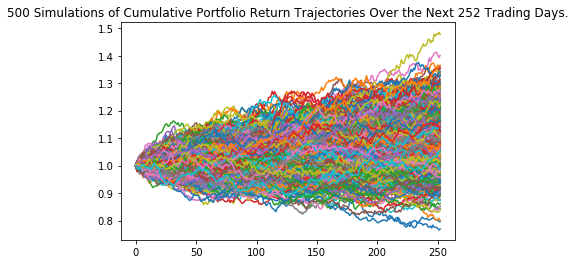

In [35]:
# Plot simulation outcomes
spagg_oneyr_line_plot = MC_spagg_one_year.plot_simulation()

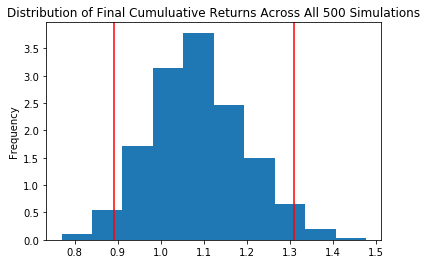

In [36]:
# Plot probability distribution and confidence intervals
spagg_oneyr_dist_plot = MC_spagg_one_year.plot_distribution()

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results
spagg_oneyr_tbl = MC_spagg_one_year.summarize_cumulative_return()

# Print summary statistics
print(spagg_oneyr_tbl)

count           500.000000
mean              1.086799
std               0.108954
min               0.769344
25%               1.008629
50%               1.080081
75%               1.158378
max               1.477316
95% CI Lower      0.890254
95% CI Upper      1.310212
Name: 252, dtype: float64


In [38]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_spagg_five_year = MCSimulation(
    portfolio_data = spagg_close,
    weights = [0.40, 0.60],
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [39]:
# Printing the simulation input data
MC_spagg_five_year.portfolio_data.head()

AGG                                                  \
            Adj Close       Close        High         Low        Open   
2011-06-30  82.949669  106.669998  106.910004  106.400002  106.870003   
2011-07-01  82.976189  106.400002  106.540001  106.269997  106.500000   
2011-07-05  83.295906  106.809998  106.820000  106.570000  106.570000   
2011-07-06  83.342690  106.870003  106.930000  106.760002  106.790001   
2011-07-07  83.108749  106.570000  106.669998  106.449997  106.629997   

                                           SPY                          \
               Volume daily_return   Adj Close       Close        High   
2011-06-30  1295600.0          NaN  108.803261  131.970001  132.179993   
2011-07-01  1970000.0    -0.002531  110.410950  133.919998  134.100006   
2011-07-05   799200.0     0.003853  110.320297  133.809998  134.080002   
2011-07-06   774600.0     0.000562  110.452179  133.970001  134.139999   
2011-07-07  1291600.0    -0.002807  111.598183  135.360001  135.699997   

                                                              
                   Low        Open       Volume daily_return  
2011-06-30  130.710007  131.139999  223322700.0          NaN  
2011-07-01  131.779999  132.089996  202385700.0     0.014776  
2011-07-05  133.389999  133.779999  165936000.0    -0.000821  
2011-07-06  133.110001  133.490005  143331600.0     0.001196  
2011-07-07  134.880005  135.160004  170464200.0     0.010375

In [40]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_spagg_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.997431  0.998358  0.996436  1.007460  1.002452  0.999690  1.002608   
2     0.992025  1.003396  0.988691  1.007237  0.999596  0.990521  1.011900   
3     0.998970  0.998931  0.993193  1.009984  1.007036  0.991884  1.003576   
4     0.999893  0.997123  0.986486  1.002628  1.007993  0.991027  1.010278   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.250100  1.440597  1.137096  1.860916  1.591427  1.824493  1.869009   
1257  1.247913  1.439087  1.122657  1.865532  1.608386  1.835947  1.893245   
1258  1.253141  1.437448  1.132530  1.878900  1.607022  1.821033  1.889503   
1259  1.256521  1.425308  1.127207  1.883286  1.614406  1.799607  1.868719   
1260  1.254302  1.425598  1.132466  1.877828  1.604640  1.801396  1.877818   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.000372  1.002582  1.011514  ...  1.000533  1.001185  0.998781   
2     0.992761  1.022666  0.998429  ...  1.006089  1.000014  0.997323   
3     0.995208  1.011076  0.989967  ...  1.006844  1.002913  1.004546   
4     1.009033  1.005257  0.985336  ...  1.004582  1.003104  1.013651   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.425838  1.327732  1.262413  ...  1.811818  1.582082  2.066439   
1257  1.430942  1.310986  1.261152  ...  1.792173  1.586636  2.078524   
1258  1.417468  1.301964  1.250386  ...  1.809662  1.583167  2.072404   
1259  1.421707  1.301170  1.240951  ...  1.810632  1.589561  2.069936   
1260  1.424853  1.300974  1.242981  ...  1.815974  1.596340  2.085066   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.003259  1.005263  0.999934  1.008870  0.995268  1.001480  1.000719  
2     0.995673  1.001612  1.003389  1.006358  0.989399  1.002905  1.006494  
3     0.992027  0.998898  1.004327  1.010009  0.988469  1.024499  1.011340  
4     0.989142  0.991850  1.003218  0.994920  0.983121  1.022402  1.018282  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.299724  2.097689  1.705707  1.133905  2.126336  1.496896  1.784972  
1257  1.287527  2.096864  1.707352  1.135093  2.136101  1.523147  1.794295  
1258  1.267647  2.085585  1.702105  1.135065  2.136771  1.515669  1.794829  
1259  1.267078  2.077517  1.705829  1.130096  2.142826  1.536730  1.797038  
1260  1.269254  2.080587  1.699959  1.133341  2.147441  1.543833  1.804758  

[1261 rows x 500 columns]

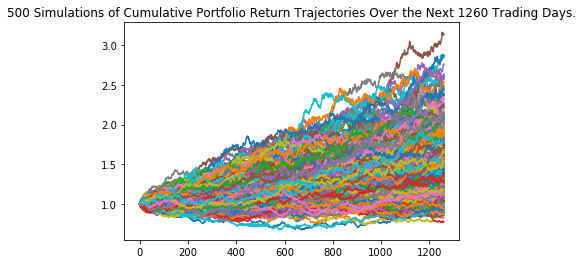

In [41]:
# Plot simulation outcomes
spagg_fiveyr_line_plot = MC_spagg_five_year.plot_simulation()

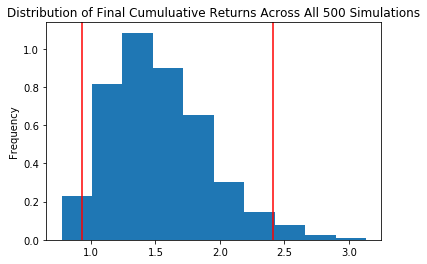

In [42]:
# Plot probability distribution and confidence intervals
spagg_fiveyr_dist_plot = MC_spagg_five_year.plot_distribution()

In [43]:
# Fetch summary statistics from the Monte Carlo simulation results
spagg_fiveyr_tbl = MC_spagg_five_year.summarize_cumulative_return()

# Print summary statistics
print(spagg_fiveyr_tbl)

count           500.000000
mean              1.536418
std               0.380883
min               0.772375
25%               1.248159
50%               1.477275
75%               1.769164
max               3.132275
95% CI Lower      0.928898
95% CI Upper      2.408430
Name: 1260, dtype: float64


In [82]:
# QQQ and SPY Data for comparisons to either the Nasdaq or S&P 500 indexes
qqqStrings = ['QQQ', 'SPY']

qqq_close = yf.download(qqqStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
qqq_close.to_csv('qqq.csv')

qqq_close = qqq_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

qqq_close = pd.read_csv('qqq.csv', header=[0, 1])
qqq_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
qqq_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(qqq_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
qqq_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
qqq_close.index.name = None

# Drop Null Information
qqq_close = qqq_close.dropna()

# Sort Multi-Index To Match Weights
qqq_close = qqq_close.reindex(sorted(qqq_close.columns), axis=1)

qqq_close

[*********************100%***********************]  2 of 2 completed


QQQ                                                  \
             Adj Close       Close        High         Low        Open   
2011-06-30   51.628384   57.049999   57.090000   56.470001   56.500000   
2011-07-01   52.406651   57.910000   57.990002   56.919998   57.080002   
2011-07-05   52.669102   58.200001   58.259998   57.830002   57.970001   
2011-07-06   52.841038   58.389999   58.490002   57.939999   58.130001   
2011-07-07   53.565018   59.189999   59.360001   58.740002   58.830002   
...                ...         ...         ...         ...         ...   
2021-06-23  347.739990  347.739990  348.920013  346.880005  347.510010   
2021-06-24  349.890015  349.890015  351.459991  349.170013  349.730011   
2021-06-25  349.459991  349.459991  350.720001  348.839996  350.470001   
2021-06-28  353.709991  353.709991  353.850006  350.720001  350.779999   
2021-06-29  354.989990  354.989990  355.019897  352.670013  353.529999   

                               SPY                                      \
                Volume   Adj Close       Close        High         Low   
2011-06-30  50347200.0  108.803261  131.970001  132.179993  130.710007   
2011-07-01  53203900.0  110.410950  133.919998  134.100006  131.779999   
2011-07-05  43128800.0  110.320297  133.809998  134.080002  133.389999   
2011-07-06  49282700.0  110.452179  133.970001  134.139999  133.110001   
2011-07-07  54799800.0  111.598183  135.360001  135.699997  134.880005   
...                ...         ...         ...         ...         ...   
2021-06-23  27188500.0  422.600006  422.600006  424.049988  422.510010   
2021-06-24  32581600.0  425.100006  425.100006  425.549988  424.619995   
2021-06-25  28627400.0  426.609985  426.609985  427.089996  425.549988   
2021-06-28  38934900.0  427.470001  427.470001  427.649994  425.890015   
2021-06-29  27855614.0  427.700012  427.700012  428.559998  427.130005   

                                     
                  Open       Volume  
2011-06-30  131.139999  223322700.0  
2011-07-01  132.089996  202385700.0  
2011-07-05  133.779999  165936000.0  
2011-07-06  133.490005  143331600.0  
2011-07-07  135.160004  170464200.0  
...                ...          ...  
2021-06-23  423.190002   49445400.0  
2021-06-24  424.890015   45110300.0  
2021-06-25  425.899994   58067900.0  
2021-06-28  427.170013   53090800.0  
2021-06-29  427.880005   34946598.0  

[2516 rows x 12 columns]

In [83]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_qqq_one_year = MCSimulation(
    portfolio_data = qqq_close,
    weights = [1, 0],
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [84]:
# Printing the simulation input data
MC_qqq_one_year.portfolio_data.head()

QQQ                                                          \
            Adj Close      Close       High        Low       Open      Volume   
2011-06-30  51.628384  57.049999  57.090000  56.470001  56.500000  50347200.0   
2011-07-01  52.406651  57.910000  57.990002  56.919998  57.080002  53203900.0   
2011-07-05  52.669102  58.200001  58.259998  57.830002  57.970001  43128800.0   
2011-07-06  52.841038  58.389999  58.490002  57.939999  58.130001  49282700.0   
2011-07-07  53.565018  59.189999  59.360001  58.740002  58.830002  54799800.0   

                                SPY                                      \
           daily_return   Adj Close       Close        High         Low   
2011-06-30          NaN  108.803261  131.970001  132.179993  130.710007   
2011-07-01     0.015075  110.410950  133.919998  134.100006  131.779999   
2011-07-05     0.005008  110.320297  133.809998  134.080002  133.389999   
2011-07-06     0.003265  110.452179  133.970001  134.139999  133.110001   
2011-07-07     0.013701  111.598183  135.360001  135.699997  134.880005   

                                                  
                  Open       Volume daily_return  
2011-06-30  131.139999  223322700.0          NaN  
2011-07-01  132.089996  202385700.0     0.014776  
2011-07-05  133.779999  165936000.0    -0.000821  
2011-07-06  133.490005  143331600.0     0.001196  
2011-07-07  135.160004  170464200.0     0.010375

In [85]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_qqq_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.005257  0.994103  1.005462  1.017375  1.021724  1.001395  1.001461   
2    0.985735  1.009209  0.989649  1.012327  0.995335  1.004637  0.998321   
3    0.976066  1.022967  0.988207  0.995625  1.011099  1.031321  1.021072   
4    0.977191  1.023906  0.983827  1.014789  0.998457  1.043897  1.015380   
..        ...       ...       ...       ...       ...       ...       ...   
248  1.199939  1.586201  0.808522  0.901246  1.159611  1.321078  1.287037   
249  1.208382  1.581277  0.821213  0.908608  1.169235  1.331312  1.296780   
250  1.214545  1.597638  0.819904  0.923730  1.156947  1.328702  1.267409   
251  1.221829  1.615137  0.838415  0.909905  1.134403  1.320167  1.262077   
252  1.256466  1.608978  0.825020  0.908084  1.152438  1.324101  1.261719   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.000103  1.021565  1.001060  ...  1.006888  1.012252  0.992804   
2    0.986227  1.012180  1.009823  ...  0.996543  1.011138  0.998472   
3    1.001186  1.015439  1.017237  ...  0.991475  1.009863  1.002096   
4    1.026640  0.992180  1.015507  ...  0.996875  0.989167  1.000374   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.376220  1.001468  1.494294  ...  1.195201  1.284495  1.000927   
249  1.384589  1.011095  1.480158  ...  1.212810  1.286273  0.985478   
250  1.380419  1.026063  1.458282  ...  1.220753  1.298849  0.996849   
251  1.413086  1.018508  1.462637  ...  1.257672  1.292919  0.993078   
252  1.427396  1.008055  1.486980  ...  1.259594  1.296388  0.986559   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.987299  0.995090  1.001277  1.005712  1.006800  1.003405  1.017653  
2    0.987266  1.005128  1.005499  1.009713  1.007309  1.017206  1.017713  
3    0.997310  1.013491  1.014066  1.026720  1.016755  1.031033  1.013850  
4    0.988827  1.014246  1.015186  1.030739  1.022218  1.040956  1.021440  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.921174  0.801680  1.313264  1.069239  1.271280  2.149203  1.097775  
249  0.926279  0.792647  1.318121  1.076015  1.268805  2.203803  1.107208  
250  0.932559  0.784788  1.302022  1.095393  1.265299  2.199315  1.120076  
251  0.918888  0.774489  1.311297  1.099413  1.253639  2.202734  1.150767  
252  0.908532  0.782297  1.310183  1.105017  1.237134  2.185554  1.153348  

[253 rows x 500 columns]

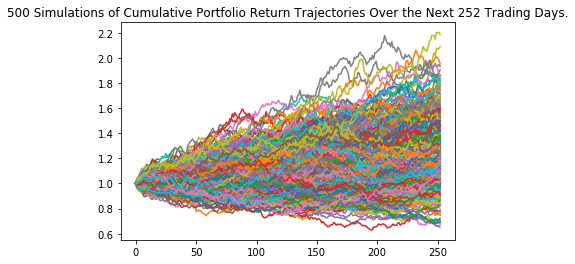

In [86]:
# Plot simulation outcomes
qqq_oneyr_line_plot = MC_qqq_one_year.plot_simulation()

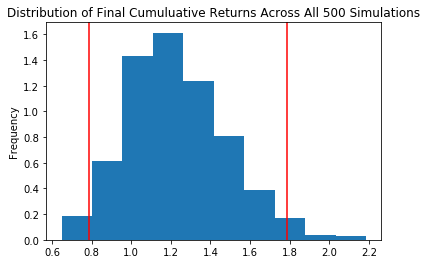

In [94]:
# Plot probability distribution and confidence intervals
qqq_oneyr_dist_plot = MC_qqq_one_year.plot_distribution()

In [95]:
# Fetch summary statistics from the Monte Carlo simulation results
qqq_oneyr_tbl = MC_qqq_one_year.summarize_cumulative_return()

# Print summary statistics
print(qqq_oneyr_tbl)

count           500.000000
mean              1.230393
std               0.249256
min               0.647879
25%               1.053613
50%               1.218084
75%               1.391589
max               2.185554
95% CI Lower      0.787750
95% CI Upper      1.785119
Name: 252, dtype: float64


In [96]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_qqq_five_year = MCSimulation(
    portfolio_data = qqq_close,
    weights = [1, 0],
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [97]:
# Printing the simulation input data
MC_qqq_five_year.portfolio_data.head()

QQQ                                                          \
            Adj Close      Close       High        Low       Open      Volume   
2011-06-30  51.628384  57.049999  57.090000  56.470001  56.500000  50347200.0   
2011-07-01  52.406651  57.910000  57.990002  56.919998  57.080002  53203900.0   
2011-07-05  52.669102  58.200001  58.259998  57.830002  57.970001  43128800.0   
2011-07-06  52.841038  58.389999  58.490002  57.939999  58.130001  49282700.0   
2011-07-07  53.565018  59.189999  59.360001  58.740002  58.830002  54799800.0   

                                SPY                                      \
           daily_return   Adj Close       Close        High         Low   
2011-06-30          NaN  108.803261  131.970001  132.179993  130.710007   
2011-07-01     0.015075  110.410950  133.919998  134.100006  131.779999   
2011-07-05     0.005008  110.320297  133.809998  134.080002  133.389999   
2011-07-06     0.003265  110.452179  133.970001  134.139999  133.110001   
2011-07-07     0.013701  111.598183  135.360001  135.699997  134.880005   

                                                  
                  Open       Volume daily_return  
2011-06-30  131.139999  223322700.0          NaN  
2011-07-01  132.089996  202385700.0     0.014776  
2011-07-05  133.779999  165936000.0    -0.000821  
2011-07-06  133.490005  143331600.0     0.001196  
2011-07-07  135.160004  170464200.0     0.010375

In [98]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_qqq_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.985370  1.000110  0.990303  1.006920  1.002304  0.995705  1.006552   
2     0.984154  0.995481  0.983544  0.986832  0.994534  0.999564  1.011224   
3     0.994063  1.006476  0.975225  0.978152  0.990470  0.994921  1.015446   
4     0.996657  0.993431  0.951211  0.992139  0.990837  0.983826  1.020163   
...        ...       ...       ...       ...       ...       ...       ...   
1256  3.933026  4.536278  2.014016  2.291689  4.994419  1.112975  2.775686   
1257  3.933786  4.614450  1.999148  2.236152  4.872753  1.122790  2.749952   
1258  3.920478  4.656589  2.010266  2.234866  4.930135  1.133090  2.756971   
1259  3.990068  4.611729  1.959709  2.204210  4.849596  1.103368  2.778142   
1260  3.932558  4.667997  1.992763  2.190112  4.865735  1.089585  2.751739   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.983011  1.013013  0.997252  ...  0.994075  1.005264  0.986037   
2     0.976275  1.007312  1.011659  ...  0.994198  1.001408  0.983750   
3     0.965339  1.016546  0.998419  ...  0.991276  0.991226  0.972022   
4     0.989008  1.033176  1.008824  ...  0.963927  1.010473  0.964864   
...        ...       ...       ...  ...       ...       ...       ...   
1256  3.168690  2.061966  2.598096  ...  2.014116  2.258815  2.518536   
1257  3.150022  2.059470  2.584240  ...  1.970855  2.268043  2.496542   
1258  3.154727  2.080480  2.572283  ...  2.001908  2.268264  2.468372   
1259  3.119341  2.080816  2.565166  ...  2.007192  2.302699  2.451753   
1260  3.108804  2.089757  2.539052  ...  1.983219  2.315118  2.412863   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.989506  1.009014  1.007519  1.021827  0.999983  1.015123  0.998800  
2     0.972347  1.005796  1.005530  1.019239  0.981986  1.022812  1.004068  
3     0.984331  0.994044  0.999048  1.020374  0.978240  1.019530  1.015209  
4     0.987424  0.996009  0.996547  1.033564  0.987289  1.015172  0.996515  
...        ...       ...       ...       ...       ...       ...       ...  
1256  3.405401  3.887858  1.325278  4.703633  3.853886  2.463988  2.174619  
1257  3.388838  3.950105  1.338309  4.604485  3.867129  2.514651  2.153051  
1258  3.379956  4.013074  1.345003  4.522552  3.905073  2.520685  2.175914  
1259  3.411606  3.963247  1.377461  4.586408  3.860853  2.559867  2.143277  
1260  3.398773  3.944179  1.383951  4.586129  3.882112  2.576134  2.115434  

[1261 rows x 500 columns]

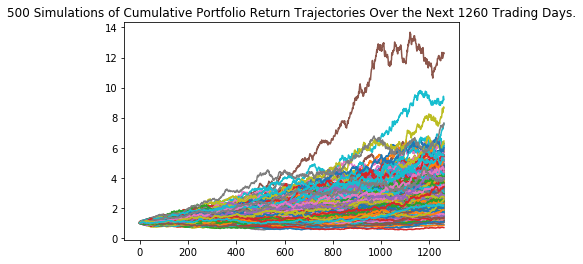

In [99]:
# Plot simulation outcomes
qqq_fiveyr_line_plot = MC_qqq_five_year.plot_simulation()

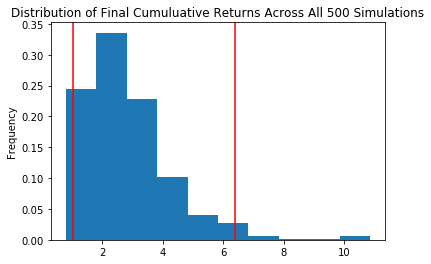

In [93]:
# Plot probability distribution and confidence intervals
qqq_fiveyr_dist_plot = MC_qqq_five_year.plot_distribution()

In [81]:
# Fetch summary statistics from the Monte Carlo simulation results
qqq_fiveyr_tbl = MC_qqq_five_year.summarize_cumulative_return()

# Print summary statistics
print(qqq_fiveyr_tbl)

count           500.000000
mean              2.728146
std               1.219181
min               0.707612
25%               1.864735
50%               2.436074
75%               3.308656
max               8.275466
95% CI Lower      1.100479
95% CI Upper      5.604586
Name: 1260, dtype: float64
